<div align="center">

# INSY 669 - Text Analytics - Group Assignment II

Sam Green  
Tarash Jain  
Rameez Rosul   
Eunice Worifah 

## **Glassdoor Review Analysis of FAANG Companies** </div>

#Load Libraries

In [ ]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import nltk
import nltk.corpus
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
pip install vaderSentiment

     |████████████████████████████████| 133kB 12.2MB/s 


# Data Acquisition

We extracted data from glassdoor using the following scraper:  
https://github.com/MatthewChatham/glassdoor-review-scraper/blob/master/main.py 

We collected data from Facebook, Amazon, Apple, Netflix and Google, from the years 2018, 2019, 2020, 2021

## Load Data

Reviews of each company was imported into different file.

In [ ]:
fb_r = pd.read_csv('glass_facebook.csv')
amazon_r = pd.read_csv('glass_amazon.csv')
apple_r = pd.read_csv('glass_apple.csv')
netflix_r = pd.read_csv('glass_netflix.csv')
google_r =  pd.read_csv('glass_google.csv')

In [ ]:
amazon_r.shape, fb_r.shape, apple_r.shape, netflix_r.shape, google_r.shape

((904, 18), (374, 18), (528, 18), (501, 18), (586, 18))

Only columns date', 'employee_title', 'employee_status', 'review_title', 'pros', 'cons' were retained and rest other columns were dropped

In [ ]:
req_col = ['date', 'employee_title', 'employee_status', 'review_title', 'pros', 'cons']
amazon_r = amazon_r[req_col]
fb_r =fb_r[req_col]
apple_r =apple_r[req_col]
netflix_r =netflix_r[req_col]
google_r =google_r[req_col]

In [ ]:
amazon_r['company'] = 'amazon'
fb_r['company'] = 'fb'
apple_r['company'] = 'apple'
netflix_r['company'] = 'netflix'
google_r['company'] = 'google'

In [ ]:
#Combining DataFrame
faang = [amazon_r, fb_r,apple_r,netflix_r, google_r]
df = pd.concat(faang)
faang_topic = df.copy()

Rows with null values were droppped

In [ ]:
df.isnull().sum()

date                 0
employee_title     133
employee_status      0
review_title         9
pros                24
cons                 2
company              0
dtype: int64

In [ ]:
# Drop any rows with null values
df.dropna(axis=0, inplace=True)
df = df.reset_index(drop=True)
df.shape

(2728, 7)

In [ ]:
df = df[df['pros'] != '#NAME?']
df = df[df['cons'] != '#NAME?']

In [ ]:
df.reset_index(drop = True, inplace= True)

### Loading data to categorize the reviews yearwise

In [ ]:
date = pd.read_excel('date.xlsx')

In [ ]:
# Bucketing the dates into subsequent quraters
df['year'] = ''
for i in range(len(df)):
  df['year'][i] = int(df['date'][i].split()[3])
  df['date'][i] = df['date'][i].split()[1]+df['date'][i].split()[3]

In [ ]:
df1 = df[df['year']>=2018]

In [ ]:
df1.shape

(2515, 8)

# Topic Modelling

In [ ]:
pip install pyLDAvis

     |████████████████████████████████| 1.7MB 10.9MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135593 sha256=065debb6521ca511e46c14a4b6891ad28177286b39243497cf9404f98443c2d8
  Stored in directory: /root/.cache/pip/wheels/74/df/b6/97234c8446a43be05c9a8687ee0db1f1b5ade5f27729187eae
Successfully built pyLDAvis


In [ ]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import nltk
import nltk.corpus
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

import gensim
from gensim import corpora

# libraries for visualization
#!pip install pyldavis
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**TOPICS - PROS**

In [ ]:
df = df1[['date', 'employee_title','pros']]
df.head()

df = df[df['pros'].notnull()]

#expand contraction words
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

df['pros1'] = df.apply(lambda row : decontracted(row['pros']), axis = 1)

#Tokenization the comments column
def token_(x):
    token = word_tokenize(x)
    return token
df['pros_token'] = df.apply(lambda row : token_(row['pros1']), axis = 1)

# Lower Casing the Tokenized comments
def lower_case(x):
    ret = []
    for words in x:
        words = words.lower()
        ret.append(words)
    return ret 
df['pros_token'] = df.apply(lambda row : lower_case(row['pros_token']), axis = 1)

# Removing Punctuation
import re 
punctutation = re.compile(r'[-.?!,:;()%\/|0-9""]')
def post_punctutation(x):
    ret = []
    for words in x:
        item = punctutation.sub("",words)
        if len(item)>0:
            ret.append(item)
    return ret 
df['pros_token'] = df.apply(lambda row : post_punctutation(row['pros_token']), axis = 1)
#len(df['Comment_token_punct'][0]), len(df['Comment_token'][0])

#Stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(x):
    filtered_sentence = []  
    for w in x:
        if w not in stop_words:
            filtered_sentence.append(w)
    return filtered_sentence
df['pros_stopwords'] = df.apply(lambda row : remove_stopwords(row['pros_token']), axis = 1)
#len(df['Comment_token_punct_stopwords'][0]),len(df['Comment_token_punct'][0]),

#POS Tagging
nltk.download('averaged_perceptron_tagger')
df['pros_tags'] = df['pros_stopwords'].apply(nltk.tag.pos_tag)

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
df['wordnet_pos'] = df['pros_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

wnl = WordNetLemmatizer()
df['lemmatized'] = df['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

# ALl the duplicate words will be removed from the text/comments including all the adjectives and verbs.
def unique_(test_list):
    res = [] 
    for i in test_list: 
        if i not in res: 
            res.append(i) 
    return res
df['pros_unique'] = df.apply(lambda row : unique_(row['lemmatized']), axis = 1)
#len(df['Comment_token_punct_stopwords_unique'][0]),len(df['lemmatized'][0]),

#select nouns only
df['nouns'] = df['wordnet_pos'].apply(lambda x: [word for (word, pos) in x if pos[0] == 'n'])

text_list=df['nouns'].tolist()
#print(text_list[0])

dictionary = corpora.Dictionary(text_list)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in text_list]

# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=5, random_state=42,
                chunksize=1000, passes=50,iterations=100);

In [ ]:
lda_model.print_topics()

[(0,
  '0.057*"opportunities" + 0.034*"company" + 0.032*"google" + 0.020*"lots" + 0.020*"salary" + 0.017*"product" + 0.015*"skills" + 0.013*"growth" + 0.013*"netflix" + 0.013*"every"'),
 (1,
  '0.129*"work" + 0.066*"place" + 0.041*"job" + 0.032*"balance" + 0.030*"people" + 0.029*"life" + 0.022*"fun" + 0.020*"environment" + 0.019*"leadership" + 0.014*"’"'),
 (2,
  '0.064*"culture" + 0.050*"company" + 0.041*"benefits" + 0.038*"pay" + 0.036*"colleagues" + 0.036*"food" + 0.023*"freedom" + 0.021*"growth" + 0.017*"*" + 0.017*"compensation"'),
 (3,
  '0.102*"pay" + 0.040*"benefits" + 0.034*"people" + 0.027*"experience" + 0.018*"care" + 0.017*"team" + 0.016*"feedback" + 0.014*"tech" + 0.014*"one" + 0.012*"days"'),
 (4,
  '0.101*"benefits" + 0.091*"work" + 0.089*"people" + 0.065*"environment" + 0.041*"company" + 0.036*"culture" + 0.035*"perks" + 0.025*"employees" + 0.025*"time" + 0.019*"hours"')]

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.135466 -0.063652       1        1  25.362043
1     -0.235227  0.110977       2        1  21.599404
2      0.111968 -0.032626       3        1  18.885246
3      0.074849 -0.218643       4        1  17.966136
0      0.183876  0.203944       5        1  16.187171, topic_info=         Term        Freq       Total Category  logprob  loglift
10       work  573.000000  573.000000  Default  30.0000  30.0000
26        pay  286.000000  286.000000  Default  29.0000  29.0000
31      place  160.000000  160.000000  Default  28.0000  28.0000
18   benefits  453.000000  453.000000  Default  27.0000  27.0000
7      people  393.000000  393.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
124       day   12.470498   40.469206   Topic5  -4.9823   0.6438
105     teams   11.835634   33.071612   Topic5  -5.0345   0.7934
72      hours   12.918766   68.915592   Topic5  -4.9470   0.1467
11     career   11.547675   52.971194   Topic5  -5.0592   0.2977
13    culture   11.502629  273.358975   Topic5  -5.0631  -1.3473

[280 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
420       5  0.923404          $
334       2  0.282753          &
334       3  0.541944          &
334       5  0.188502          &
313       2  0.948491         ''
...     ...       ...        ...
1         2  0.987381  workplace
284       4  0.941084      would
673       1  0.105398       year
673       2  0.895886       year
240       2  0.976389          ’

[314 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 3, 4, 1])

In [ ]:
#recount the frequency of all the words
from nltk.probability import FreqDist
fdist = FreqDist()
for i in range(len(df)):
    for word in text_list[i]:
        fdist[word]+=1
word_freqs2 = pd.DataFrame(fdist.items(), columns = ['word', 'frequency']).sort_values(by = ['frequency'], ascending = False)
word_freqs2

word_freqs2.head(20)

,word,frequency
5,work,654
18,benefits,547
8,people,434
26,pay,327
3,company,314
13,culture,293
0,environment,278
30,place,161
12,opportunities,139
25,team,137


**TOPICS - CONS**

In [ ]:
df = df1[['date', 'employee_title','cons']]
df.head()

df = df[df['cons'].notnull()]

#expand contraction words
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

df['pros1'] = df.apply(lambda row : decontracted(row['cons']), axis = 1)

#Tokenization the comments column
def token_(x):
    token = word_tokenize(x)
    return token
df['pros_token'] = df.apply(lambda row : token_(row['pros1']), axis = 1)

# Lower Casing the Tokenized comments
def lower_case(x):
    ret = []
    for words in x:
        words = words.lower()
        ret.append(words)
    return ret 
df['pros_token'] = df.apply(lambda row : lower_case(row['pros_token']), axis = 1)

# Removing Punctuation
import re 
punctutation = re.compile(r'[-.?!,:;()%\/|0-9""]')
def post_punctutation(x):
    ret = []
    for words in x:
        item = punctutation.sub("",words)
        if len(item)>0:
            ret.append(item)
    return ret 
df['pros_token'] = df.apply(lambda row : post_punctutation(row['pros_token']), axis = 1)
#len(df['Comment_token_punct'][0]), len(df['Comment_token'][0])

#Stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(x):
    filtered_sentence = []  
    for w in x:
        if w not in stop_words:
            filtered_sentence.append(w)
    return filtered_sentence
df['pros_stopwords'] = df.apply(lambda row : remove_stopwords(row['pros_token']), axis = 1)
#len(df['Comment_token_punct_stopwords'][0]),len(df['Comment_token_punct'][0]),

#POS Tagging
nltk.download('averaged_perceptron_tagger')
df['pros_tags'] = df['pros_stopwords'].apply(nltk.tag.pos_tag)

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
df['wordnet_pos'] = df['pros_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

wnl = WordNetLemmatizer()
df['lemmatized'] = df['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

# ALl the duplicate words will be removed from the text/comments including all the adjectives and verbs.
def unique_(test_list):
    res = [] 
    for i in test_list: 
        if i not in res: 
            res.append(i) 
    return res
df['pros_unique'] = df.apply(lambda row : unique_(row['lemmatized']), axis = 1)
#len(df['Comment_token_punct_stopwords_unique'][0]),len(df['lemmatized'][0]),

#select nouns only
df['nouns'] = df['wordnet_pos'].apply(lambda x: [word for (word, pos) in x if pos[0] == 'n'])

text_list=df['nouns'].tolist()
#print(text_list[0])

dictionary = corpora.Dictionary(text_list)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in text_list]

# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=5, random_state=42,
                chunksize=1000, passes=50,iterations=100);


In [ ]:
lda_model.print_topics()

[(0,
  '0.041*"management" + 0.033*"people" + 0.029*"employees" + 0.025*"culture" + 0.020*"company" + 0.017*"advice" + 0.016*"``" + 0.016*"\'\'" + 0.013*"like" + 0.013*"one"'),
 (1,
  '0.053*"none" + 0.041*"’" + 0.016*"team" + 0.014*"helpful" + 0.011*"”" + 0.009*"time" + 0.009*"netflix" + 0.009*"“" + 0.009*"support" + 0.009*"think"'),
 (2,
  '0.177*"helpfu" + 0.053*"management" + 0.046*"cons" + 0.036*"nothing" + 0.034*"advice" + 0.031*"lot" + 0.030*"company" + 0.026*"work" + 0.023*"time" + 0.013*"would"'),
 (3,
  '0.086*"helpfu" + 0.029*"management" + 0.019*"performance" + 0.018*"people" + 0.018*"lots" + 0.017*"company" + 0.016*"opportunities" + 0.016*"politics" + 0.014*"things" + 0.013*"process"'),
 (4,
  '0.108*"work" + 0.081*"helpfu" + 0.067*"hours" + 0.042*"balance" + 0.033*"life" + 0.016*"time" + 0.015*"management" + 0.013*"day" + 0.011*"could" + 0.011*"times"')]

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.001963  0.213675       1        1  32.537418
4     -0.128944 -0.175355       2        1  21.248205
2     -0.124767 -0.022372       3        1  19.392268
1      0.289424 -0.078970       4        1  14.557329
3     -0.033750  0.063022       5        1  12.264780, topic_info=        Term         Freq        Total Category  logprob  loglift
1     helpfu  1103.000000  1103.000000  Default  30.0000  30.0000
7       work   555.000000   555.000000  Default  29.0000  29.0000
19     hours   251.000000   251.000000  Default  28.0000  28.0000
21      none   138.000000   138.000000  Default  27.0000  27.0000
115     cons   157.000000   157.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
252   career    14.806477    39.835062   Topic5  -4.9884   1.1088
3     advice    23.487050   256.551614   Topic5  -4.5270  -0.2924
8        get    15.609896    81.102257   Topic5  -4.9355   0.4506
109  manager    14.260276    63.124897   Topic5  -5.0260   0.6108
61     could    13.463644    61.589031   Topic5  -5.0835   0.5779

[294 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1074      1  0.962260      &
455       5  0.950652      '
128       1  0.995698     ''
1133      1  0.220268      *
1133      2  0.220268      *
...     ...       ...    ...
145       5  0.027442  years
22        1  0.171843      ’
22        4  0.827971      ’
895       4  0.952854      “
1175      4  0.989085      ”

[361 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 3, 2, 4])

In [ ]:
#recount the frequency of all the words
from nltk.probability import FreqDist
fdist = FreqDist()
for i in range(len(df)):
    for word in text_list[i]:
        fdist[word]+=1
word_freqs2 = pd.DataFrame(fdist.items(), columns = ['word', 'frequency']).sort_values(by = ['frequency'], ascending = False)
word_freqs2

word_freqs2.head(20)

,word,frequency
2,helpfu,1271
3,management,633
7,work,632
18,hours,307
5,advice,302
40,company,284
43,people,280
32,time,267
273,helpful,194
11,culture,192


**INSIGHT - The topics are poorly defined, so we chose to use the Bi-gram Word Frequency method to generate more defined topics**

# **Bi-Gram Word Frequency**

## Pre-processing

In [ ]:
df = df1

In [ ]:
#Converting the values to string
def string_(x):
  x = str(x)
def lower(x):
    l = x.lower()
    return l
df['review_title'] = df.apply(lambda row : lower(row['review_title']), axis = 1)
df['pros'] = df.apply(lambda row : lower(row['pros']), axis = 1)
df['cons'] = df.apply(lambda row : lower(row['cons']), axis = 1)
df['date'] = df.apply(lambda row : lower(row['date']), axis = 1)
df['employee_title'] = df.apply(lambda row : lower(row['employee_title']), axis = 1)
df['employee_status'] = df.apply(lambda row : lower(row['employee_status']), axis = 1)

In [ ]:
#Keeping orignal reviews, pros and cons data for sentiment analysis
df['review_title_o'] = df.apply(lambda row : lower(row['review_title']), axis = 1)
df['pros_o'] = df.apply(lambda row : lower(row['pros']), axis = 1)
df['cons_o'] = df.apply(lambda row : lower(row['cons']), axis = 1)

In [ ]:
#Tokenization the comments column
def token_(x):
    token = word_tokenize(x)
    return token
df['review_title'] = df.apply(lambda row : token_(row['review_title']), axis = 1)
df['pros'] = df.apply(lambda row : token_(row['pros']), axis = 1)
df['cons'] = df.apply(lambda row : token_(row['cons']), axis = 1)

In [ ]:
# Lower Casing the Tokenized comments
def lower_case(x):
    ret = []
    for words in x:
        words = words.lower()
        ret.append(words)
    return ret 
df['review_title'] = df.apply(lambda row : lower_case(row['review_title']), axis = 1)
df['pros'] = df.apply(lambda row : lower_case(row['pros']), axis = 1)
df['cons'] = df.apply(lambda row : lower_case(row['cons']), axis = 1)

In [ ]:
# Removing Punctuation
import re 
punctutation = re.compile(r'[-.?!,:;()%\/|0-9""]')
def post_punctutation(x):
    ret = []
    for words in x:
        item = punctutation.sub("",words)
        if len(item)>0:
            ret.append(item)
    return ret 
df['review_title'] = df.apply(lambda row : post_punctutation(row['review_title']), axis = 1)
df['pros'] = df.apply(lambda row : post_punctutation(row['pros']), axis = 1)
df['cons'] = df.apply(lambda row : post_punctutation(row['cons']), axis = 1)

In [ ]:
#Stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(x):
    filtered_sentence = []  
    for w in x:
        if w not in stop_words:
            filtered_sentence.append(w)
    return filtered_sentence
df['review_title'] = df.apply(lambda row : remove_stopwords(row['review_title']), axis = 1)
df['pros'] = df.apply(lambda row : remove_stopwords(row['pros']), axis = 1)
df['cons'] = df.apply(lambda row : remove_stopwords(row['cons']), axis = 1)

In [ ]:
df.head(2)

,date,employee_title,employee_status,review_title,pros,cons,company,year,review_title_o,pros_o,cons_o
0,jan2021,warehouse associate,current employee,[good],"[good, environment, workplace]","[find, deficiency, workplace, helpfu]",amazon,2021,good,very good environment in the workplace\n,i have not find any deficiency in my workplace...
1,feb2021,warehouse worker,current employee,"[good, service]","[hard, working, job]","[friendly, working, management, coverage, advi...",amazon,2021,good service,hard working in this job\n,friendly working in management coverage\nadvic...


##Load Employee Position Data

We constructed the data to categorize different employee in different department. 

In [ ]:
# Importing emp_title as Dataframe
emp_title = pd.read_csv('emp_title.csv')
# Function to lower case the model names and brand names
def lower(x):
  x = str(x)
  l = x.lower()
  return l
# Applying the 'lower' function to emp_title dataframe in both the columns
emp_title['employee_title'] = emp_title.apply(lambda row : lower(row['employee_title']), axis = 1)
emp_title['domain'] = emp_title.apply(lambda row : lower(row['domain']), axis = 1)

In [ ]:
df.reset_index(drop = True, inplace=True)
df['department'] = ''
#Replacing the model names with brand names
for i in range(len(df)):
  if df['employee_title'][i] in emp_title['employee_title'].tolist():
    df['department'][i] = emp_title['domain'][emp_title['employee_title'].tolist().index(df['employee_title'][i])]

## Word Count to normalize the bigram frequency

To normalize the values of bigrams, we need to compute the number of reviews in each department in respective companies. Counter is that dataframe which we used in further bigram frequency counts section

In [ ]:
# Calculating the number of words in review for respective company, department
def countwords(x):
  a = len(x)
  return a
# Applying the 'countwords' function to dataframe in both the columns (pros and cons)
df['pro_words_count'] = df.apply(lambda row : countwords(row['pros']), axis = 1)
df['con_words_count'] = df.apply(lambda row : countwords(row['cons']), axis = 1)


In [ ]:
df['cum_pro_word'] = df.groupby(['company','department'])['pro_words_count'].transform('sum')
df['cum_con_word'] = df.groupby(['company','department'])['con_words_count'].transform('sum')
df['total_review'] = df.groupby(['company','department'])['pro_words_count'].transform('count')

counter = df.drop_duplicates(subset = ['cum_pro_word' ,	'cum_con_word' ,	'total_review'])[['company','department','cum_pro_word' ,	'cum_con_word' ,	'total_review']]
counter.reset_index(drop=True, inplace=True)

In [ ]:
counter

,company,department,cum_pro_word,cum_con_word,total_review
0,amazon,supply chain,1987,3424,308
1,amazon,admin,429,720,79
2,amazon,technology,1144,1478,139
3,amazon,hr,57,64,11
4,amazon,operations,741,1133,135
5,amazon,sales,214,325,26
6,amazon,marketing,33,52,6
7,amazon,finance,31,31,5
8,amazon,analytics,188,217,27
9,amazon,product,68,73,7


## Frequency Counts

These two dataframes below were made to store the frequency of the bigrams

In [ ]:
vec_df_pros = pd.DataFrame([],columns=['frequency','bigram', 'company', 'department'] )
vec_df_cons = pd.DataFrame([],columns=['frequency','bigram', 'company', 'department'] )

In [ ]:
dep = df['department'].unique()
com = df['company'].unique()
rev = ['pros_o' ,'cons_o']

We used the CountVectorizer library to identify the number of bigrams and counted the frequency of respective bigrams

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stoplist = stopwords.words('english') 
c_vec = CountVectorizer(stop_words=stoplist, ngram_range=(2,2))

for i in com:
  for j in dep:
      if j in df[df['company'] == i]['department'].unique():
        temp = df[(df['company'] == i) & (df['department'] == j)]
        # matrix of bigrams
        ngrams = c_vec.fit_transform(temp['pros_o'])
        # count frequency of bigrams
        count_values = ngrams.toarray().sum(axis=0)
        # list of bigrams
        vocab = c_vec.vocabulary_
        df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)).rename(columns={0: 'frequency', 1:'bigram'})
        df_ngram['company'] = i
        df_ngram['department'] = j
        
        #Combining DataFrame
        con_cat = [vec_df_pros,df_ngram]
        vec_df_pros = pd.concat(con_cat)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stoplist = stopwords.words('english') 
c_vec = CountVectorizer(stop_words=stoplist, ngram_range=(2,2))

for i in com:
  for j in dep:
      if j in df[df['company'] == i]['department'].unique():
        temp = df[(df['company'] == i) & (df['department'] == j)]
        # matrix of bigrams
        ngrams = c_vec.fit_transform(temp['cons_o'])
        # count frequency of bigrams
        count_values = ngrams.toarray().sum(axis=0)
        # list of bigrams
        vocab = c_vec.vocabulary_
        df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)).rename(columns={0: 'frequency', 1:'bigram'})
        df_ngram['company'] = i
        df_ngram['department'] = j
        
        #Combining DataFrame
        con_cat = [vec_df_cons,df_ngram]
        vec_df_cons = pd.concat(con_cat)


In [ ]:
vec_df_pros.to_csv('pro_words_list.csv')
vec_df_cons.to_csv('con_words_list.csv')

We further categorized the bigrams into broader categories such as Career Growth, Work Life, Environment, etc.

To do that we imported the data pros_list and cons_list, performed find/replace, and substituted the bigrams with their corresponding categories.


In [ ]:
#Loading External Data to club bigrams
pro_list = pd.read_csv('pros_list.csv')
cons_list = pd.read_csv('cons_list.csv')

In [ ]:
vec_df_pros.reset_index(inplace=True, drop = True)
vec_df_cons.reset_index(inplace=True, drop = True)

In [ ]:
vec_df_pros['word'] = ''
for i in range(len(vec_df_pros)):
  if vec_df_pros['bigram'][i] in pro_list['Row Labels'].unique():
    vec_df_pros['word'][i] =  pro_list['Category'][pro_list['Row Labels'].tolist().index(vec_df_pros['bigram'][i])]

vec_df_cons['word'] = ''
for i in range(len(vec_df_cons)):
  if vec_df_cons['bigram'][i] in cons_list['Row Labels'].unique():
    vec_df_cons['word'][i] =  cons_list['Category'][cons_list['Row Labels'].tolist().index(vec_df_cons['bigram'][i])]

There were bigrams which has no meaning and to avoid recounting, we assigned them a 'Null' value, and further removed them from analysis.

In [ ]:
# Removing Rows which did not have significant frequency
vec_df_pros = vec_df_pros[vec_df_pros['word'] != 'Null']
vec_df_cons = vec_df_cons[vec_df_cons['word'] != 'Null']
vec_df_cons = vec_df_cons[vec_df_cons["word"] != '']
counter = df.drop_duplicates(subset = ['cum_pro_word' ,	'cum_con_word' ,	'total_review'])[['company','department','cum_pro_word' ,	'cum_con_word' ,	'total_review']]
counter.reset_index(drop=True, inplace=True)

In [ ]:
vec_df_pros['freq'] = vec_df_pros.groupby(['company','department','word'])['frequency'].transform('sum')
vec_df_cons['freq'] = vec_df_cons.groupby(['company','department','word'])['frequency'].transform('sum')

In [ ]:
pro_ = vec_df_pros.drop_duplicates(subset = ['freq'])[['company','department','word','freq']]
pro_.reset_index(drop=True, inplace=True)

cons_ = vec_df_cons.drop_duplicates(subset = ['freq'])[['company','department','word','freq']]
cons_.reset_index(drop=True, inplace=True)

The below chunk of code is to normalize the frequency of the bigram frequency. We divide the nunber of words with the number of reviews in respective company's department

In [ ]:
a = pro_['company'].unique().tolist()
d = pro_['department'].unique().tolist()
for i in a:
  for j in d:
    pro_.loc[(pro_['company'] == i) & (pro_['department'] == j), 'freq'] = pro_.loc[(pro_['company'] == i) & (pro_['department'] == j), 'freq'] / counter[(counter['company'] == i) & (counter['department'] == j)]['total_review'].values

for i in a:
  for j in d:
    cons_.loc[(cons_['company'] == i) & (cons_['department'] == j), 'freq'] = cons_.loc[(cons_['company'] == i) & (cons_['department'] == j), 'freq'] / counter[(counter['company'] == i) & (counter['department'] == j)]['total_review'].values
cons_.dropna(axis=0, inplace=True)
pro_.dropna(axis=0, inplace=True)

In [ ]:
cons_

,company,department,word,freq
0,amazon,supply chain,Management,0.340909
1,amazon,supply chain,Work Life,0.762987
2,amazon,supply chain,Support,0.233766
3,amazon,supply chain,Environment,0.058442
4,amazon,supply chain,Career Growth,0.071429
5,amazon,supply chain,work life,0.003247
6,amazon,admin,Management,0.316456
7,amazon,admin,Work Life,0.696203
8,amazon,admin,Environment,0.025316
9,amazon,admin,Career Growth,0.050633


In [ ]:
pro_.head(10)

,company,department,word,freq
0,amazon,supply chain,Pay,0.262987
1,amazon,supply chain,Benefits,0.233766
2,amazon,supply chain,Work Life,0.292208
3,amazon,supply chain,Environment,0.285714
4,amazon,supply chain,,0.685065
5,amazon,supply chain,Perks,0.022727
6,amazon,admin,Environment,0.544304
7,amazon,admin,Pay,0.164557
8,amazon,admin,Work Life,0.392405
9,amazon,admin,Benefits,0.063291


In [ ]:
pro_.to_csv('pro_.csv')
cons_.to_csv('cons_.csv')

## Sentiment Analysis

We used the vader sentiment analyser to compute the coumpund sentiment score of each review in pro_reviews and con_reviews section.

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score['compound']

In [ ]:
df['pros_sentiment'] = df.apply(lambda row : sentiment_analyzer_scores(row['pros_o']), axis = 1)
df['cons_sentiment'] = df.apply(lambda row : sentiment_analyzer_scores(row['cons_o']), axis = 1)

### Mean Sentiment Analysis

The computed sentiment score was aggreagted for each department in the different company

In [ ]:
sentiment = df.groupby(['department','company']).mean()
sentiment.to_csv('sentiment_.csv')

In [ ]:
#fig = plt.figure(figsize = (10,5))
#sns.barplot(x = 'department', y  = 'pros_sentiment', data=sentiment , palette='viridis',)

In [ ]:
#fig = plt.figure(figsize = (10,5))
#sns.barplot(x = 'department', y  = 'cons_sentiment', data=sentiment , palette='viridis',)

### Mean Sentiment Analysis Yearwise

The average sentiment score was computed and grouped by 'employee_status', 'year' &'company' to analyze the reviews sentiment pre and post covid.

In [ ]:
grouped_multiple = df.groupby(['employee_status', 'year', 'company']).agg({'pros_sentiment': ['mean'], 'cons_sentiment': ['mean']})
grouped_multiple['department'] =  grouped_multiple.index
grouped_multiple.to_csv('group_sentiment.csv')

In [ ]:
grouped_multiple

pros_sentiment  ...                          department
                                         mean  ...                                    
employee_status   year company                 ...                                    
current employee  2018 apple         0.691979  ...    (current employee , 2018, apple)
                       fb            0.966033  ...       (current employee , 2018, fb)
                       google        0.705200  ...   (current employee , 2018, google)
                       netflix       0.737444  ...  (current employee , 2018, netflix)
                  2019 amazon        0.589601  ...   (current employee , 2019, amazon)
                       apple         0.646700  ...    (current employee , 2019, apple)
                       fb            0.210750  ...       (current employee , 2019, fb)
                       google        0.704675  ...   (current employee , 2019, google)
                       netflix       0.710827  ...  (current employee , 2019, netflix)
                  2020 amazon        0.529605  ...   (current employee , 2020, amazon)
                       apple         0.628829  ...    (current employee , 2020, apple)
                       fb            0.761044  ...       (current employee , 2020, fb)
                       google        0.602282  ...   (current employee , 2020, google)
                       netflix       0.564054  ...  (current employee , 2020, netflix)
                  2021 amazon        0.521198  ...   (current employee , 2021, amazon)
                       apple         0.693370  ...    (current employee , 2021, apple)
                       fb            0.643532  ...       (current employee , 2021, fb)
                       google        0.612717  ...   (current employee , 2021, google)
                       netflix       0.550252  ...  (current employee , 2021, netflix)
former employee   2018 apple         0.699606  ...     (former employee , 2018, apple)
                       fb            0.756600  ...        (former employee , 2018, fb)
                       google        0.666000  ...    (former employee , 2018, google)
                       netflix       0.690163  ...   (former employee , 2018, netflix)
                  2019 amazon        0.486134  ...    (former employee , 2019, amazon)
                       apple         0.717204  ...     (former employee , 2019, apple)
                       fb            0.603640  ...        (former employee , 2019, fb)
                       google        0.760212  ...    (former employee , 2019, google)
                       netflix       0.721483  ...   (former employee , 2019, netflix)
                  2020 amazon        0.517843  ...    (former employee , 2020, amazon)
                       apple         0.632778  ...     (former employee , 2020, apple)
                       fb            0.519475  ...        (former employee , 2020, fb)
                       google        0.627412  ...    (former employee , 2020, google)
                       netflix       0.552907  ...   (former employee , 2020, netflix)
                  2021 amazon        0.480338  ...    (former employee , 2021, amazon)
                       apple         0.617970  ...     (former employee , 2021, apple)
                       fb            0.646234  ...        (former employee , 2021, fb)
                       google        0.638164  ...    (former employee , 2021, google)
                       netflix       0.632469  ...   (former employee , 2021, netflix)

[38 rows x 3 columns]

# **WORD CLOUD**

In [ ]:
!pip install wordcloud

**PROS**

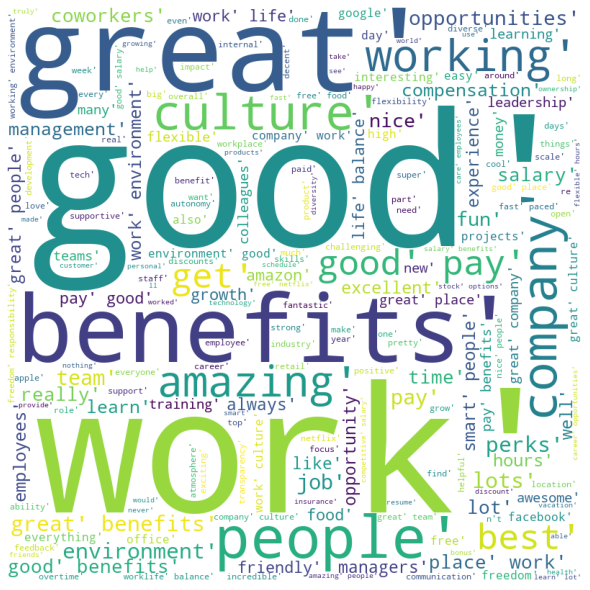

In [ ]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
  

df = df1

  
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in df.pros: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

**CONS**

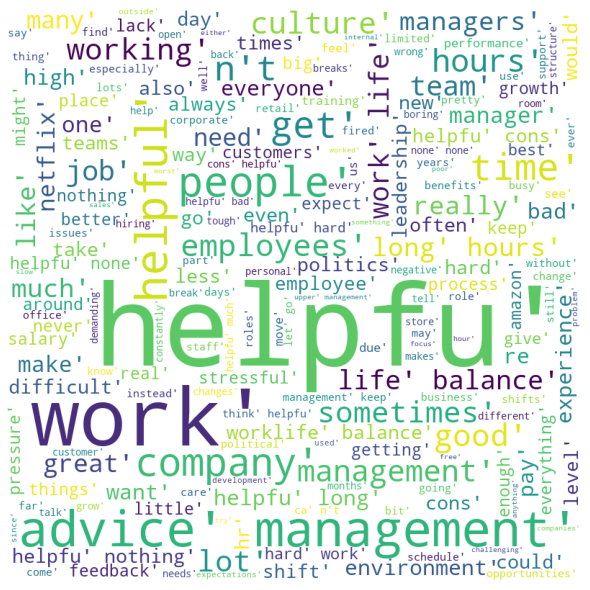

In [ ]:
df = df1

  
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in df.cons: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()